In [1]:
# Make all directories and subdirectories

import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
basedir = '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker'

os.mkdir(str(basedir) + str('/train'))
os.mkdir(str(basedir) + str('/val'))
os.mkdir(str(basedir) + str('/test'))

image_list = ['t1', 't1gd', 't2', 'flair', 'swi', 'adc', 'fa', 'md', 'asl', 'dwi']

for i in range(len(image_list)):
    os.mkdir(str(basedir) + str('/train/') + str(image_list[i]))
    os.mkdir(str(basedir) + str('/val/') + str(image_list[i]))
    os.mkdir(str(basedir) + str('/test/') + str(image_list[i]))

In [2]:
# read in all image paths from csv
base = '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/Results'
ADC = pd.read_csv(str(base) + str('/ADC.csv'))
ASL = pd.read_csv(str(base) + str('/ASL.csv'))
FA = pd.read_csv(str(base) + str('/DTI_eddy_FA.csv'))
MD = pd.read_csv(str(base) + str('/DTI_eddy_MD.csv'))
DWI = pd.read_csv(str(base) + str('/DWI_bias.csv'))
FLAIR = pd.read_csv(str(base) + str('/FLAIR_bias.csv'))
SWI = pd.read_csv(str(base) + str('/SWI_bias.csv'))
T1 = pd.read_csv(str(base) + str('/T1_bias.csv'))
T1GD = pd.read_csv(str(base) + str('/T1gad_bias.csv'))
T2 = pd.read_csv(str(base) + str('/T2_bias.csv'))
# get brain mask paths so each image will be completely dark in non-brain areas
mask = ADC['Brain_Mask'].to_list()
ADC = ADC['Image'].to_list()
ASL = ASL['Image'].to_list()
FA = FA['Image'].to_list()
MD = MD['Image'].to_list()
DWI = DWI['Image'].to_list()
FLAIR = FLAIR['Image'].to_list()
SWI = SWI['Image'].to_list()
T1 = T1['Image'].to_list()
T1GD = T1GD['Image'].to_list()
T2 = T2['Image'].to_list()

In [3]:
# manually define cutoffs for training, validation, and testing
num_subs = len(ADC)
# where validation indices start - use first 80% of data for training
val_cutoff = round(num_subs*0.8) 
# where test indices start
test_cutoff = val_cutoff + round((num_subs-val_cutoff)/2)
print(val_cutoff)
print(test_cutoff)

401
451


In [315]:
# process all images - read in a nifti file and convert to an anxial slice png
def preprocess_img(img, i, val_cutoff, test_cutoff, subfolder, mask):
    from PIL import Image as im
    outdir = '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker'
    sub_id = img.split('/')[-7]
    mask = nib.load(mask[:])
    mask = np.array(mask.dataobj)
    mask = np.rot90(mask[:, :, 95], 3)
    img = nib.load(img[:])
    img = np.array(img.dataobj)
    # normalize image intensities
    _min = np.amin(img[:, :, :])
    _max = np.amax(img[:, :, :])  
    img = ((img[:, :, :] - _min) * (1/(_max - _min) * 255.0)).astype('uint8')
    img = np.rot90(img[:, :, 95], 3)
    img = im.fromarray(np.multiply(mask, img))
    img = img.convert("L")
    if i <= val_cutoff -1:
        end_path = str('/train/') + str(subfolder) + str('/') + str(sub_id) + str('_') + str(subfolder) + str('.png')
    elif i > test_cutoff-1:
        end_path = str('/test/') + str(subfolder) + str('/') + str(sub_id) + str('_') + str(subfolder) + str('.png')
    else:
        end_path = str('/val/') + str(subfolder) + str('/') + str(sub_id) + str('_') + str(subfolder) + str('.png')
    outpath = str(outdir) + str(end_path)
    img.save(outpath)   
        
import nibabel as nib
from PIL import Image as im
for i in range(num_subs):
    preprocess_img(ADC[i], i, val_cutoff, test_cutoff, 'adc', mask[i])
    preprocess_img(ASL[i], i, val_cutoff, test_cutoff, 'asl', mask[i])
    preprocess_img(FA[i], i, val_cutoff, test_cutoff, 'fa', mask[i])
    preprocess_img(MD[i], i, val_cutoff, test_cutoff, 'md', mask[i])
    preprocess_img(DWI[i], i, val_cutoff, test_cutoff, 'dwi', mask[i])
    preprocess_img(FLAIR[i], i, val_cutoff, test_cutoff, 'flair', mask[i])
    preprocess_img(SWI[i], i, val_cutoff, test_cutoff, 'swi', mask[i])
    preprocess_img(T1[i], i, val_cutoff, test_cutoff, 't1', mask[i])
    preprocess_img(T1GD[i], i, val_cutoff, test_cutoff, 't1gd', mask[i])
    preprocess_img(T2[i], i, val_cutoff, test_cutoff, 't2', mask[i])

In [14]:
# Build model and create training/validation batches
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
outdir = '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker'
train_path = str(outdir) + str("/train")
val_path = str(outdir) + str("/val")

img_datagen = ImageDataGenerator(rescale=1./255,
                                    fill_mode="nearest",
                                    rotation_range=180, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    shear_range=0.0, 
                                    zoom_range=0.8,  
                                    vertical_flip=1, 
                                    horizontal_flip=1,
                                    validation_split=0.2
                                    )
train_batches = img_datagen.flow_from_directory(directory=train_path, target_size=(224,224), 
                    classes=['adc', 'asl', 'dwi', 'fa', 'flair', 'md', 'swi', 't1', 't1gd', 't2'], batch_size=128)
img_datagen2 = ImageDataGenerator(rescale=1./255, fill_mode="nearest")
val_batches = img_datagen2.flow_from_directory(directory=val_path, target_size=(224, 224), 
                    classes=['adc', 'asl', 'dwi', 'fa', 'flair', 'md', 'swi', 't1', 't1gd', 't2'], batch_size=128)

vgg16_model = tf.keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

for layer in model.layers:
    layer.trainable = True
model.add(Dense(10, activation='softmax'))
# View final model architecture
print(model.summary())

Found 4010 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                   

In [15]:
# set optimization and how to monitor training
# fit model, save losses, and save model
opt = Adam(learning_rate=1e-4, decay=1e-4 / 500)
model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics = [tf.keras.metrics.CategoricalCrossentropy()])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, verbose=1, mode='auto', 
                        restore_best_weights=True)
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=val_batches,
            validation_steps=len(val_batches),
            callbacks = monitor, 
            epochs=500, 
            verbose=2)
model_path = str(outdir) + str("/image_picker") + str(".h5")
model.save(model_path)
hist_df = pd.DataFrame(history.history) 
csv_path = str(outdir) + str("/image_picker") + str(".csv")
hist_df.to_csv(csv_path)

Epoch 1/500
32/32 - 738s - loss: 2.7204 - categorical_crossentropy: 2.7204 - val_loss: 2.2367 - val_categorical_crossentropy: 2.2367 - 738s/epoch - 23s/step
Epoch 2/500
32/32 - 744s - loss: 2.0251 - categorical_crossentropy: 2.0251 - val_loss: 1.8477 - val_categorical_crossentropy: 1.8477 - 744s/epoch - 23s/step
Epoch 3/500
32/32 - 736s - loss: 1.5891 - categorical_crossentropy: 1.5891 - val_loss: 1.2061 - val_categorical_crossentropy: 1.2061 - 736s/epoch - 23s/step
Epoch 4/500
32/32 - 746s - loss: 1.1036 - categorical_crossentropy: 1.1036 - val_loss: 0.9603 - val_categorical_crossentropy: 0.9603 - 746s/epoch - 23s/step
Epoch 5/500
32/32 - 750s - loss: 0.8322 - categorical_crossentropy: 0.8322 - val_loss: 0.4983 - val_categorical_crossentropy: 0.4983 - 750s/epoch - 23s/step
Epoch 6/500
32/32 - 745s - loss: 0.5988 - categorical_crossentropy: 0.5988 - val_loss: 0.4081 - val_categorical_crossentropy: 0.4081 - 745s/epoch - 23s/step
Epoch 7/500
32/32 - 739s - loss: 0.3984 - categorical_cros

Epoch 53/500
32/32 - 738s - loss: 0.0730 - categorical_crossentropy: 0.0730 - val_loss: 0.0543 - val_categorical_crossentropy: 0.0543 - 738s/epoch - 23s/step
Epoch 54/500
32/32 - 733s - loss: 0.0520 - categorical_crossentropy: 0.0520 - val_loss: 0.0622 - val_categorical_crossentropy: 0.0622 - 733s/epoch - 23s/step
Epoch 55/500
32/32 - 735s - loss: 0.0376 - categorical_crossentropy: 0.0376 - val_loss: 0.0593 - val_categorical_crossentropy: 0.0593 - 735s/epoch - 23s/step
Epoch 56/500
32/32 - 744s - loss: 0.0244 - categorical_crossentropy: 0.0244 - val_loss: 0.0768 - val_categorical_crossentropy: 0.0768 - 744s/epoch - 23s/step
Epoch 57/500
32/32 - 784s - loss: 0.0350 - categorical_crossentropy: 0.0350 - val_loss: 0.0574 - val_categorical_crossentropy: 0.0574 - 784s/epoch - 24s/step
Epoch 58/500
32/32 - 1236s - loss: 0.0454 - categorical_crossentropy: 0.0454 - val_loss: 0.0696 - val_categorical_crossentropy: 0.0696 - 1236s/epoch - 39s/step
Epoch 59/500
32/32 - 1607s - loss: 0.0644 - catego

Epoch 105/500
32/32 - 1518s - loss: 0.0340 - categorical_crossentropy: 0.0340 - val_loss: 0.0683 - val_categorical_crossentropy: 0.0683 - 1518s/epoch - 47s/step
Epoch 106/500
32/32 - 1532s - loss: 0.0301 - categorical_crossentropy: 0.0301 - val_loss: 0.1208 - val_categorical_crossentropy: 0.1208 - 1532s/epoch - 48s/step
Epoch 107/500
32/32 - 1535s - loss: 0.0346 - categorical_crossentropy: 0.0346 - val_loss: 0.1128 - val_categorical_crossentropy: 0.1128 - 1535s/epoch - 48s/step
Epoch 108/500
32/32 - 1575s - loss: 0.0444 - categorical_crossentropy: 0.0444 - val_loss: 0.0539 - val_categorical_crossentropy: 0.0539 - 1575s/epoch - 49s/step
Epoch 109/500
32/32 - 1535s - loss: 0.0357 - categorical_crossentropy: 0.0357 - val_loss: 0.0553 - val_categorical_crossentropy: 0.0553 - 1535s/epoch - 48s/step
Epoch 110/500
32/32 - 1494s - loss: 0.0242 - categorical_crossentropy: 0.0242 - val_loss: 0.0854 - val_categorical_crossentropy: 0.0854 - 1494s/epoch - 47s/step
Epoch 111/500
32/32 - 1532s - loss

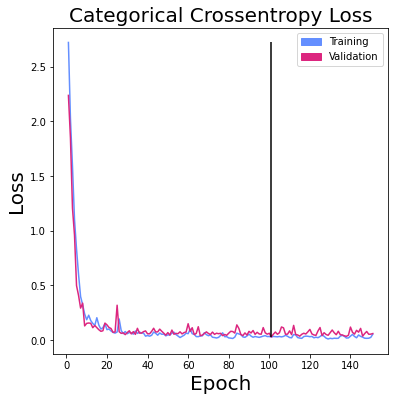

In [297]:
# view the losses to make sure the model is learning
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
f = plt.figure(figsize=(6, 6))
losses = pd.read_csv('/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/image_picker.csv')
color_palette = ['#648fff', '#dc267f']
sns.set_palette(color_palette)

a = sns.lineplot(y=losses['categorical_crossentropy'], x=range(1, len(losses)+1))
a.axes.set_title("Categorical Crossentropy Loss", fontsize=20)
a = sns.lineplot(y=losses['val_categorical_crossentropy'], x=range(1, len(losses)+1))
a.set_xlabel('Epoch', fontsize=20)
a.set_ylabel('Loss', fontsize=20)
plt.vlines(len(losses)-50, min(losses['val_categorical_crossentropy']), 
           max(losses['categorical_crossentropy']), color='k')
train = mpatches.Patch(color='#648fff', label='Training')
val = mpatches.Patch(color='#dc267f', label='Validation')
plt.legend(handles=[train, val])
plt.savefig('losses.tiff', dpi=600, format="tiff")

In [21]:
# reload the model if needed
import keras
model = keras.models.load_model("/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/image_picker.h5")

In [299]:
# Get all test image paths and store in test_imagePaths list
import os
test_imagePaths = []
# traverse whole directory
for root, dirs, files in os.walk(r'/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test'):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('.png'):
            test_imagePaths.append((os.path.join(root, file)))

In [300]:
# sort the list for easy interpretation
test_imagePaths.sort()

In [301]:
# Check image paths to make sure they make sense
print(test_imagePaths)

['/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-492_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-493_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-494_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-495_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-496_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-497_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-498_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-499_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/i

In [302]:
# Manually create the test_y list from the test_path strings
import pandas as pd
import numpy as np
test_y = []
for i in range(len(test_imagePaths)):
    if "adc" in test_imagePaths[i]:
        test_y.append(int(0))
    elif "asl" in test_imagePaths[i]:
        test_y.append(int(1))
    elif "dwi" in test_imagePaths[i]:
        test_y.append(int(2))
    elif "fa" in test_imagePaths[i]:
        test_y.append(int(3))
    elif "flair" in test_imagePaths[i]:
        test_y.append(int(4))
    elif "md" in test_imagePaths[i]:
        test_y.append(int(5))
    elif "swi" in test_imagePaths[i]:
        test_y.append(int(6))
    elif "t1." in test_imagePaths[i]:
        test_y.append(int(7)) 
    elif "t1gd" in test_imagePaths[i]:
        test_y.append(int(8))
    elif "t2" in test_imagePaths[i]:
        test_y.append(int(9))
test_y = np.array(test_y)
test_df = pd.DataFrame()
test_df['id'] = test_imagePaths
test_df['score'] = test_y

In [303]:
# Check that the output of test_y makes sense - zeros, ones, twos, etc
print(test_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

In [304]:
import tensorflow as tf

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, fill_mode = "nearest")

import keras
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='id',
    y_col='score',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=1,
    shuffle=False)

Found 500 validated image filenames.


In [305]:
# Get probabilities for each class and predictions
probs = model.predict(test_images).tolist()
preds = np.argmax(probs, axis=1)
print(preds)

In [307]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(preds), np.array(test_y))
print("Overall Accuracy: ", accuracy)

Overall Accuracy:  0.994


In [308]:
# Prep y_values to generate ROC Curve
from sklearn.preprocessing import label_binarize
y_test = label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

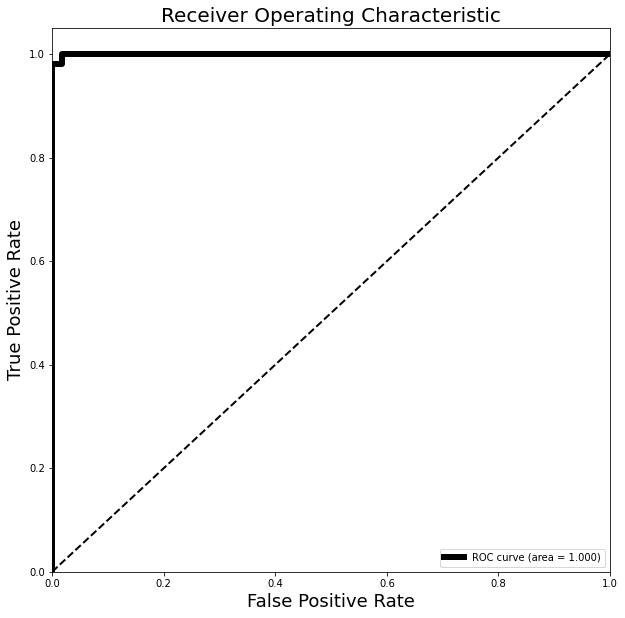

In [313]:
# Make ROC Curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, probs)

fpr = dict()
tpr = dict()
n_classes = 10
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], np.array(probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
img_list = ['ADC', 'ASL', 'DWI', 'FA', 'FLAIR', 'MD', 'SWI', 'T1', 'T1GD', 'T2']
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), np.array(probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
n_classes = 10
plt.figure(figsize=(10, 10))
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="black",
    lw=6,
    label="ROC curve (area = %0.3f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize='18')
plt.title("Receiver Operating Characteristic", fontsize=20)
plt.legend(loc="lower right")
plt.savefig('roc.tiff', dpi=600, format="tiff")

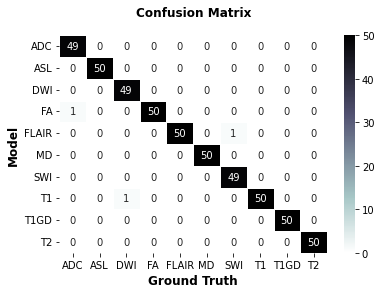

In [312]:
# Plot Confusion matrix to determine which image types were missed
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cnf_matrix = confusion_matrix(preds, test_y)
class_names = ['ADC', 'ASL', 'DWI', 'FA', 'FLAIR', 'MD', 'SWI', 'T1', 'T1GD', 'T2']
s = sns.heatmap(df, vmin=0, vmax=50, annot=True, cmap='bone_r', linewidth=0.5)
s.xaxis.set_ticklabels(class_names); s.yaxis.set_ticklabels(class_names)
s.set(xlabel='Ground Truth', ylabel='Model')
s.set_xlabel('Ground Truth', fontsize=12, weight='bold')
s.set_ylabel('Model', fontsize=12, weight='bold')
plt.yticks(rotation=0) 
s.axes.set_title('Confusion Matrix', fontsize=12, weight='bold', y=1.06)
plt.rcParams['savefig.facecolor']='white'
plt.savefig('confusion.tiff', dpi=600, format="tiff")

In [165]:
# determine indices of wrong images and image path names for manual inspection
wrong_images = []
for i in range(len(preds)):
    if preds[i] != test_y[i]:
        wrong_images.append(test_imagePaths[i])
        print(i)
print(wrong_images)

12
141
341
['/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-504_adc.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/dwi/UCSF-PDGM-533_dwi.png', '/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/swi/UCSF-PDGM-533_swi.png']


In [166]:
# use gradcam to see which parts of image are most valuable in making predictions
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

/project/radiology/ANSIR_lab/shared/s175064_workspace/UCSF_IDH_Trial/image_picker/test/adc/UCSF-PDGM-510_adc.png


(-0.5, 223.5, 223.5, -0.5)

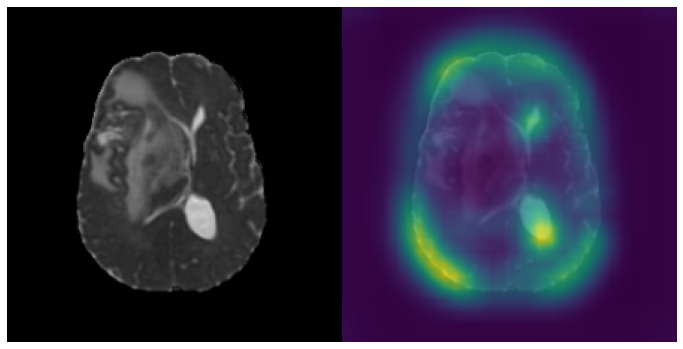

In [295]:
# runs gradcam function for a specific image index
import cv2
img_idx = 18
image = cv2.imread(test_imagePaths[img_idx])
print(test_imagePaths[img_idx])
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
image = tf.reshape(image, [1, 224, 224, 3])
preds_gradcam = model.predict(image) 
i = np.argmax(preds_gradcam[0])
icam = GradCAM(model, i, 'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread(test_imagePaths[img_idx])
image = cv2.resize(image, (224, 224))

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.25)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
fig, ax = plt.subplots(1, 2, figsize=(12,8))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].imshow(image, cmap="gray")
ax[0].axis('off')
ax[1].imshow(output)
ax[1].axis('off')